In [132]:
""" Time-series analysis for the trend of the average temperature in the last 80 years for Berlin-Marzahn."""

' Time-series analysis for the trend of the average temperature in the last 80 years for Berlin-Marzahn.'

Download mean temperature data for Berlin-Marzahn at: https://www.ecad.eu/dailydata/customquery.php and copy into data folder!

In [93]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools
from sklearn.model_selection import cross_val_score, GridSearchCV


In [94]:
def extract_years(df, start_year, end_year):
    # returns a time window of the datafram
    df = df[df.index.to_series().between(start_year, end_year)]
    return df

## Load and clean data

In [95]:
data = pd.read_csv("./data/TG_STAID004561.txt", skiprows=18)
# only pick rows with "valid" data. see .txt file for furhter information
data = data[data[data.columns[3]]==0]
data[data.columns[2]] = data[data.columns[2]]*0.1 # convert to °C

data.drop([data.columns[3]], inplace=True, axis=1) # not needed anymore
data.drop([data.columns[0]], inplace=True, axis=1) # not needed for us
# give sensible column name
data.rename(columns={data.columns[0]: 'date', data.columns[1]: 'temp'}, inplace=True)
#data.reset_index(drop=True, inplace=True)
data.set_index(pd.to_datetime(data['date'], format='%Y%m%d'), inplace=True, drop=True)
data.drop('date', inplace=True, axis=1)

# final data frame, date vs. mean temp in °C
temp_ts = data # temperature time series
temp_ts.info() # no nan values check

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22403 entries, 1961-01-01 to 2022-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    22403 non-null  float64
dtypes: float64(1)
memory usage: 350.0 KB


In [96]:
## add features and describe periodicity
temp_ts['timestep'] = list(range(len(temp_ts))) ## add timestep at every data point
seasonal_dummies = pd.get_dummies(temp_ts.index.month, prefix='month', drop_first=True).set_index(temp_ts.index)
temp_ts = temp_ts.join(seasonal_dummies) # add dummies for each month

## Perform linear regression to obtain seasonality and trend

In [97]:
X = temp_ts['timestep']
X = sm.add_constant(X)
y = temp_ts['temp']

trend_model = sm.OLS(y, X).fit()
# add predicted trend to table
temp_ts['trend'] = trend_model.predict(X)
## perform  OLS regression on seasonality
X = pd.concat([temp_ts['timestep'], seasonal_dummies], axis=1)
X = sm.add_constant(X)
y = temp_ts['temp']

#poly = PolynomialFeatures(degree=2, interaction_only=True)
#X = poly.fit_transform(X)

seasonality_model_no_lag = sm.OLS(y, X).fit()
# add seasonality trend to table
temp_ts['seasonality'] = seasonality_model_no_lag.predict(X)

# add remainder
temp_ts['remainder'] = temp_ts['temp'] - temp_ts['seasonality']

In [98]:
# reorder columns
temp_ts = temp_ts[['timestep','temp','trend', 'seasonality', 'remainder', 'month_2', 'month_3', 'month_4', 'month_5',
    'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]

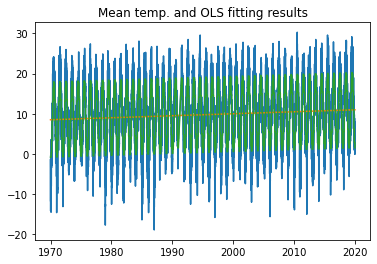

In [130]:
# plot results for one year
temp_ts_windowd = extract_years(temp_ts, '1970', '2020')
fig, ax = plt.subplots()
ax.plot(temp_ts_windowd['temp'])
ax.plot(temp_ts_windowd['trend'])
ax.plot(temp_ts_windowd['seasonality'])
plt.title("Mean temp. and OLS fitting results")
plt.show()


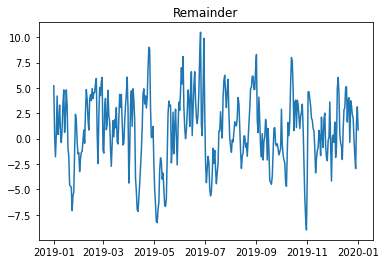

In [113]:
plt.plot(extract_years(temp_ts['remainder'], '2019', '2020'))
plt.title("Remainder")
plt.show()

## Autoregressive model

In [101]:
temp_ts['lag1'] = temp_ts['remainder'].shift(1)
temp_ts['lag1'] = temp_ts['lag1'].fillna(method="bfill")  #fill nan
# calculate Pearson's correlation
corr, _ = pearsonr(temp_ts['lag1'], temp_ts['remainder'])
corr

0.8060865776248995

c:\Users\Me\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lag1', ylabel='remainder'>

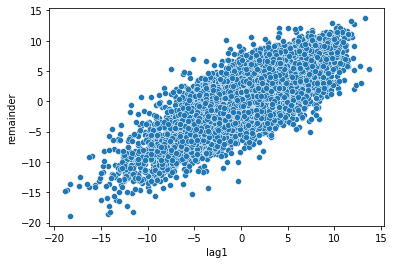

In [117]:
# visualize the lags
sns.scatterplot(temp_ts['lag1'], temp_ts['remainder'])

c:\Users\Me\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lag2', ylabel='remainder'>

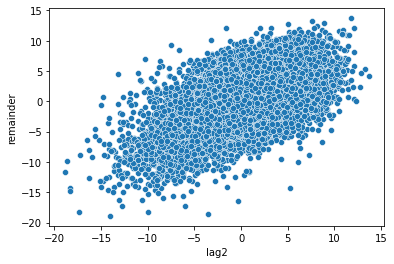

In [103]:
temp_ts['lag2'] = temp_ts['remainder'].shift(2)
temp_ts['lag2'] = temp_ts['lag2'].fillna(method="bfill")  #fill nan
# calculate Pearson's correlation
corr, _ = pearsonr(temp_ts['lag2'], temp_ts['remainder'])
sns.scatterplot(temp_ts['lag2'], temp_ts['remainder'])

c:\Users\Me\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lag3', ylabel='remainder'>

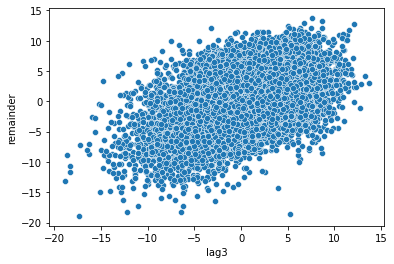

In [120]:
temp_ts['lag3'] = temp_ts['remainder'].shift(3)
temp_ts['lag3'] = temp_ts['lag3'].fillna(method="bfill")  #fill nan
# calculate Pearson's correlation
corr, _ = pearsonr(temp_ts['lag3'], temp_ts['remainder'])
sns.scatterplot(temp_ts['lag3'], temp_ts['remainder'])

Figure(432x288)


c:\Users\Me\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


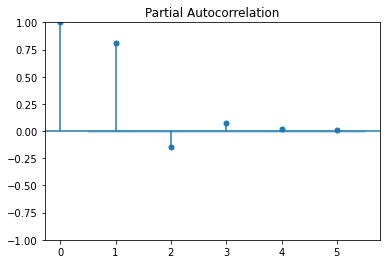

In [105]:
print(plot_pacf(temp_ts['remainder'], lags = 5))

## Repeat regression including lags

In [106]:
# remove the 3rd leg, 1 and 2 already added above
temp_ts.drop('lag3', inplace=True, axis=1)

## perform  OLS regression on trend
X = pd.concat([temp_ts['timestep'], temp_ts['lag1'], temp_ts['lag1']], axis=1)
X = sm.add_constant(X)
y = temp_ts['temp']

trend_model = sm.OLS(y, X).fit()
# add predicted trend to table
temp_ts['trend_with_lag'] = trend_model.predict(X)
## perform  OLS regression on seasonality
X = pd.concat([temp_ts['timestep'], seasonal_dummies, temp_ts['lag1'], temp_ts['lag1']], axis=1)
X = sm.add_constant(X)
y = temp_ts['temp']

#poly = PolynomialFeatures(degree=2, interaction_only=True)
#X = poly.fit_transform(X)

seasonality_model = sm.OLS(y, X).fit()
# add seasonality trend to table
temp_ts['seasonality_with_lag'] = seasonality_model.predict(X)

# add remainder
temp_ts['remainder_with_lag'] = temp_ts['temp'] - temp_ts['seasonality_with_lag']


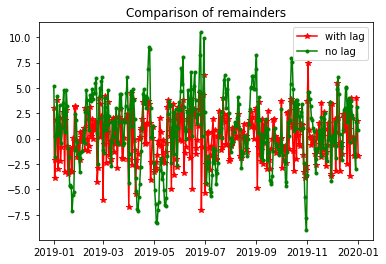

In [107]:
plt.plot(extract_years(temp_ts['remainder_with_lag'], '2019', '2020'), 'r*-', label='with lag')
plt.plot(extract_years(temp_ts['remainder'], '2019', '2020'), 'g.-', label='no lag')
plt.legend()
plt.title("Comparison of remainders")
plt.show()

## Unit root analysis

In [108]:
# check how stationary the remainder is with augmented dickey fuller test
def print_adf(data):
        
        """ Prints the results of the augmented Dickey Fuller Test"""
        
        adf_stats, p, used_lag, n_obs, levels, information_criterion = \
                statsmodels.tsa.stattools.adfuller(data, maxlag=30)
        
        print(f"""   
                adf: {round(adf_stats,2)}
                p: {p} 
                used lag: {used_lag} 
                number of observations: {n_obs}
                {round(levels['1%'],2)} (p=0.01; CI=99%) 
                {round(levels['5%'],2)} (p=0.05; CI=95%)
                {round(levels['10%'],2)} (p=0.1 CI=90%) 
                information criterion (AIC): {information_criterion}
                """)

print_adf(temp_ts['remainder'])

print("Interpretation: The p-value is 0.0, therefore we can say with almost absolute certainty that the Null Hypothesis can be rejected. \
Thus, the remainder has no unit roots and is stationary.")

   
                adf: -21.45
                p: 0.0 
                used lag: 30 
                number of observations: 22372
                -3.43 (p=0.01; CI=99%) 
                -2.86 (p=0.05; CI=95%)
                -2.57 (p=0.1 CI=90%) 
                information criterion (AIC): 100268.43108160791
                
Interpretation: The p-value is 0.0, therefore we can say with almost absolute certainty that the Null Hypothesis can be rejected. Thus, the remainder has no unit roots and is stationary.


## ARIMA

In [122]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
arima_error = []
tuple_list = []
# brute-force hyperparameter tuning
for p in range(5):
    for d in [0, 1]:
        for q in range(5):
            arima = ARIMA(endog= temp_ts['remainder'], order = (p, d, q)).fit()
            temp_ts['arima_prediction'] = arima.predict()
            arima_error.append(round(mean_absolute_error(temp_ts['remainder'], temp_ts['arima_prediction']),4))
            tuple_list.append((p, d, q))

c:\Users\Me\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Me\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Me\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Me\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [129]:
# get best parameters
min_error = min(arima_error)
min_error_idx = arima_error.index(min_error)
best_tuple = tuple_list[min_error_idx]
print(f"ARIMA order with the lowest error is: {best_tuple}")

ARIMA order with the lowest error is: (1, 0, 1)


## Predicting the future

In [109]:
temp_ts.tail(5)


,timestep,temp,trend,seasonality,remainder,month_2,month_3,month_4,month_5,month_6,...,month_8,month_9,month_10,month_11,month_12,lag1,lag2,trend_with_lag,seasonality_with_lag,remainder_with_lag
date,,,,,,,,,,,,,,,,,,,,,
2022-10-27,22398,14.1,11.146031,11.144783,2.955217,0,0,0,0,0,...,0,0,1,0,0,0.855346,2.155475,11.848020,11.829955,2.270045
2022-10-28,22399,16.7,11.146168,11.144912,5.555088,0,0,0,0,0,...,0,0,1,0,0,2.955217,0.855346,13.570329,13.522953,3.177047
2022-10-29,22400,16.6,11.146306,11.145041,5.454959,0,0,0,0,0,...,0,0,1,0,0,5.555088,2.955217,15.702705,15.619040,0.980960
2022-10-30,22401,15.2,11.146443,11.145170,4.054830,0,0,0,0,0,...,0,0,1,0,0,5.454959,5.555088,15.620723,15.538447,-0.338447
2022-10-31,22402,13.3,11.146580,11.145299,2.154701,0,0,0,0,0,...,0,0,1,0,0,4.054830,5.454959,14.472569,14.409824,-1.109824


In [110]:
# predict one timestep into the future - here the 2022-11-01
timestep = temp_ts['timestep'].max() + 1
months = [0] * 9 + [1] + [0] # pick november, and drop january like in dummy creation
lag1 = temp_ts.loc['2022-10-01', 'lag1']
lag2 = temp_ts.loc['2022-10-01', 'lag2']


In [111]:
X_future = [1.0] # the constant
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future = pd.DataFrame([X_future])


In [112]:
seasonality_model.predict(X_future)

0    1.403112
dtype: float64